In [28]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
import graphviz as gr
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS

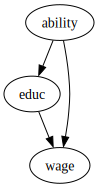

In [9]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g

# Quarter of Birth and the Effect of Education on Wage

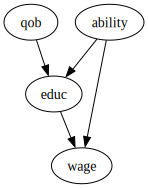

In [10]:
g = gr.Digraph()

g.edge("qob", "educ")
g.edge("ability", "educ")
g.edge("educ", "wage")
g.edge("ability", "wage")

g

In [11]:
data = pd.read_csv("https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/ak91.csv")
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


## The 1st Stage: check if is a valid IV

Text(0, 0.5, 'Years of Schooling')

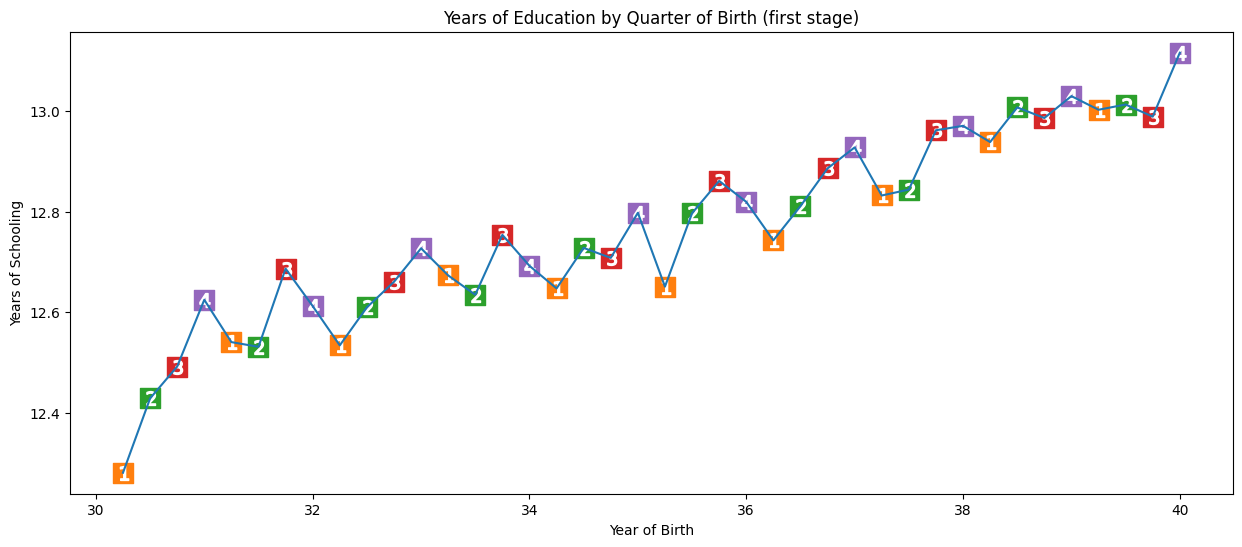

In [14]:
group_data = (data.groupby([
    "year_of_birth", "quarter_of_birth"
])[["log_wage", "years_of_schooling"]]
.mean()
.reset_index()
.assign(time_of_birth = lambda d: d["year_of_birth"] + d["quarter_of_birth"]/4))

plt.figure(figsize=(15, 6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"])
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling")

In [22]:
factor_data = pd.concat([data,
                         pd.get_dummies(data["quarter_of_birth"].astype(int),
                                              dtype="int", prefix="q", prefix_sep="")],
                                              axis=1)

In [25]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

first_stage.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.3370,0.038,295.142,0.000,11.262,11.412
C(year_of_birth)[T.31.0],0.1432,0.025,5.687,0.000,0.094,0.193
C(year_of_birth)[T.32.0],0.2110,0.025,8.490,0.000,0.162,0.260
C(year_of_birth)[T.33.0],0.2708,0.025,10.767,0.000,0.222,0.320
C(year_of_birth)[T.34.0],0.3097,0.025,12.432,0.000,0.261,0.359
C(year_of_birth)[T.35.0],0.3750,0.025,15.154,0.000,0.326,0.423
C(year_of_birth)[T.36.0],0.4202,0.025,16.968,0.000,0.372,0.469
C(year_of_birth)[T.37.0],0.4810,0.025,19.614,0.000,0.433,0.529
C(year_of_birth)[T.38.0],0.5626,0.024,23.146,0.000,0.515,0.610
C(year_of_birth)[T.39.0],0.6019,0.024,24.858,0.000,0.554,0.649


## The Reduced Form

In [26]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

reduced_form.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.7138,0.008,708.514,0.000,5.698,5.730
C(year_of_birth)[T.31.0],0.0044,0.005,0.835,0.404,-0.006,0.015
C(year_of_birth)[T.32.0],0.0035,0.005,0.678,0.497,-0.007,0.014
C(year_of_birth)[T.33.0],0.0057,0.005,1.074,0.283,-0.005,0.016
C(year_of_birth)[T.34.0],0.0047,0.005,0.907,0.364,-0.006,0.015
C(year_of_birth)[T.35.0],-0.0024,0.005,-0.464,0.643,-0.013,0.008
C(year_of_birth)[T.36.0],0.0011,0.005,0.220,0.826,-0.009,0.011
C(year_of_birth)[T.37.0],2.702e-05,0.005,0.005,0.996,-0.010,0.010
C(year_of_birth)[T.38.0],0.0047,0.005,0.929,0.353,-0.005,0.015
C(year_of_birth)[T.39.0],-0.0034,0.005,-0.663,0.507,-0.013,0.007


## IV

In [27]:
reduced_form.params["q4"] / first_stage.params["q4"]

0.08530286492096699

In [30]:
iv2sls = IV2SLS.from_formula("log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]", factor_data).fit()
iv2sls

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               log_wage   R-squared:                      0.1217
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1215
No. Observations:              329509   F-statistic:                 1.028e+04
Date:                Sat, Jul 08 2023   P-value (F-stat)                0.0000
Time:                        21:57:35   Distribution:                 chi2(60)
Cov. Estimator:                robust                                         
                                                                              
                                     Parameter Estimates                                     
=============================================================================================
                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------
Intercept                     4.7468     0.2904     16.348     0.0000      4.1777      5.3158
C(year_of_birth)[T.31.0]     -0.0078     0.0063    -1.2384     0.2156     -0.0201      0.0045
C(year_of_birth)[T.32.0]     -0.0145     0.0073    -1.9698     0.0489     -0.0288   -7.25e-05
C(year_of_birth)[T.33.0]     -0.0174     0.0086    -2.0367     0.0417     -0.0342     -0.0007
C(year_of_birth)[T.34.0]     -0.0217     0.0094    -2.3012     0.0214     -0.0401     -0.0032
C(year_of_birth)[T.35.0]     -0.0344     0.0108    -3.1821     0.0015     -0.0556     -0.0132
C(year_of_birth)[T.36.0]     -0.0347     0.0118    -2.9309     0.0034     -0.0579     -0.0115
C(year_of_birth)[T.37.0]     -0.0410     0.0132    -3.0976     0.0020     -0.0670     -0.0151
C(year_of_birth)[T.38.0]     -0.0433     0.0152    -2.8520     0.0043     -0.0730     -0.0135
C(year_of_birth)[T.39.0]     -0.0547     0.0161    -3.3887     0.0007     -0.0864     -0.0231
C(state_of_birth)[T.2.0]      0.2272     0.1060     2.1433     0.0321      0.0194      0.4350
C(state_of_birth)[T.4.0]      0.1215     0.0404     3.0083     0.0026      0.0424      0.2007
C(state_of_birth)[T.5.0]      0.0431     0.0123     3.5103     0.0004      0.0190      0.0671
C(state_of_birth)[T.6.0]      0.1351     0.0557     2.4268     0.0152      0.0260      0.2442
C(state_of_birth)[T.8.0]      0.0920     0.0435     2.1143     0.0345      0.0067      0.1774
C(state_of_birth)[T.9.0]      0.1051     0.0429     2.4511     0.0142      0.0211      0.1891
C(state_of_birth)[T.10.0]     0.0796     0.0280     2.8408     0.0045      0.0247      0.1346
C(state_of_birth)[T.11.0]     0.1162     0.0572     2.0317     0.0422      0.0041      0.2282
C(state_of_birth)[T.12.0]    -0.0157     0.0278    -0.5651     0.5720     -0.0701      0.0387
C(state_of_birth)[T.13.0]    -0.0155     0.0119    -1.3003     0.1935     -0.0389      0.0079
C(state_of_birth)[T.15.0]     0.1256     0.0575     2.1857     0.0288      0.0130      0.2382
C(state_of_birth)[T.16.0]     0.0718     0.0497     1.4450     0.1485     -0.0256      0.1693
C(state_of_birth)[T.17.0]     0.1762     0.0429     4.1080     0.0000      0.0921      0.2603
C(state_of_birth)[T.18.0]     0.1341     0.0288     4.6494     0.0000      0.0775      0.1906
C(state_of_birth)[T.19.0]     0.0735     0.0382     1.9251     0.0542     -0.0013      0.1483
C(state_of_birth)[T.20.0]     0.0420     0.0462     0.9081     0.3638     -0.0486      0.1326
C(state_of_birth)[T.21.0]     0.1194     0.0153     7.7839     0.0000      0.0893      0.1495
C(state_of_birth)[T.22.0]     0.0883     0.0150     5.8957     0.0000      0.0589      0.1176
C(state_of_birth)[T.23.0]    -0.0236     0.0219    -1.0779     0.2811     -0.0666      0.0193
C(state_of_birth)[T.24.0]     0.1048     0.0225     4.6641     0.0000      0.0608      0.1489
C(state_of_birth)[T.25.0]     0.0783     0.0463     1.6916     0.0907     -0.0124      0.1691
C(state_of_birth)[T.26.0]

# Multiples instruments

In [31]:
iv_many_zs = IV2SLS.from_formula("log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]", factor_data).fit()
iv_many_zs

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               log_wage   R-squared:                      0.0929
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0927
No. Observations:              329509   F-statistic:                    9996.1
Date:                Sat, Jul 08 2023   P-value (F-stat)                0.0000
Time:                        22:10:05   Distribution:                 chi2(60)
Cov. Estimator:                robust                                         
                                                                              
                                     Parameter Estimates                                     
=============================================================================================
                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------
Intercept                     4.4924     0.2224     20.197     0.0000      4.0564      4.9283
C(year_of_birth)[T.31.0]     -0.0110     0.0059    -1.8606     0.0628     -0.0226      0.0006
C(year_of_birth)[T.32.0]     -0.0192     0.0066    -2.9241     0.0035     -0.0321     -0.0063
C(year_of_birth)[T.33.0]     -0.0235     0.0074    -3.1792     0.0015     -0.0380     -0.0090
C(year_of_birth)[T.34.0]     -0.0286     0.0080    -3.5948     0.0003     -0.0442     -0.0130
C(year_of_birth)[T.35.0]     -0.0428     0.0089    -4.7871     0.0000     -0.0603     -0.0253
C(year_of_birth)[T.36.0]     -0.0441     0.0097    -4.5612     0.0000     -0.0631     -0.0252
C(year_of_birth)[T.37.0]     -0.0518     0.0107    -4.8557     0.0000     -0.0727     -0.0309
C(year_of_birth)[T.38.0]     -0.0559     0.0121    -4.6325     0.0000     -0.0795     -0.0322
C(year_of_birth)[T.39.0]     -0.0682     0.0128    -5.3317     0.0000     -0.0933     -0.0431
C(state_of_birth)[T.2.0]      0.1878     0.1038     1.8090     0.0705     -0.0157      0.3912
C(state_of_birth)[T.4.0]      0.0905     0.0335     2.6972     0.0070      0.0247      0.1562
C(state_of_birth)[T.5.0]      0.0398     0.0122     3.2621     0.0011      0.0159      0.0636
C(state_of_birth)[T.6.0]      0.0871     0.0431     2.0235     0.0430      0.0027      0.1715
C(state_of_birth)[T.8.0]      0.0560     0.0346     1.6154     0.1062     -0.0119      0.1238
C(state_of_birth)[T.9.0]      0.0690     0.0338     2.0419     0.0412      0.0028      0.1353
C(state_of_birth)[T.10.0]     0.0668     0.0266     2.5095     0.0121      0.0146      0.1189
C(state_of_birth)[T.11.0]     0.0689     0.0455     1.5156     0.1296     -0.0202      0.1581
C(state_of_birth)[T.12.0]    -0.0373     0.0229    -1.6278     0.1036     -0.0821      0.0076
C(state_of_birth)[T.13.0]    -0.0108     0.0115    -0.9353     0.3497     -0.0334      0.0118
C(state_of_birth)[T.15.0]     0.0916     0.0523     1.7516     0.0798     -0.0109      0.1941
C(state_of_birth)[T.16.0]     0.0310     0.0398     0.7787     0.4362     -0.0470      0.1090
C(state_of_birth)[T.17.0]     0.1394     0.0334     4.1777     0.0000      0.0740      0.2048
C(state_of_birth)[T.18.0]     0.1103     0.0230     4.7876     0.0000      0.0652      0.1555
C(state_of_birth)[T.19.0]     0.0415     0.0302     1.3761     0.1688     -0.0176      0.1006
C(state_of_birth)[T.20.0]     0.0028     0.0363     0.0772     0.9384     -0.0683      0.0739
C(state_of_birth)[T.21.0]     0.1293     0.0137     9.4495     0.0000      0.1025      0.1561
C(state_of_birth)[T.22.0]     0.0801     0.0139     5.7647     0.0000      0.0529      0.1074
C(state_of_birth)[T.23.0]    -0.0382     0.0193    -1.9796     0.0477     -0.0760     -0.0004
C(state_of_birth)[T.24.0]     0.0885     0.0191     4.6389     0.0000      0.0511      0.1259
C(state_of_birth)[T.25.0]     0.0386     0.0360     1.0743     0.2827     -0.0319      0.1091
C(state_of_birth)[T.26.0]